# **Background**

Medical Image Segmentation is the process of automatic detection of boundaries within images. In this exercise, we train a convolutional neural network with [U-Net](https://arxiv.org/abs/1505.04597) architecture, which training strategy relies on the strong use of data augmentation to improve the efficiency of available annotated samples.

Our motivation is to automatically identify lung opacities in chest x-rays for the [RSNA Pneumonia Detection Challenge](https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/leaderboard).

The model training is done with two chest x-rays datasets:
- [Montgomery County and Shenzhen Hospital](https://www.kaggle.com/datasets/kmader/pulmonary-chest-xray-abnormalities).
- The Montgomery County dataset includes manually segmented lung masks while Shenzhen Hospital dataset was manually segmented by [Stirenko et al](https://arxiv.org/abs/1803.01199).
- The lung segmentation masks were dilated to load lung boundary information within the training net and the images were resized to 512x512 pixels.




# **Data preparation**



## 1. Prepare the input segmentation directory structure.

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K  # Alias it to 'K'
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

from glob import glob
from tqdm import tqdm

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
path = "/content/drive/MyDrive/Deep Learning/datasets"


Mounted at /content/drive


In [ ]:
# Define the segmentation directory inside your base path
os.makedirs(f"{path}/segmentation", exist_ok=True)
segmentation_path = os.path.join(path, "segmentation")

# Create the required directories
os.makedirs(f"{segmentation_path}/test", exist_ok=True)
os.makedirs(f"{segmentation_path}/train", exist_ok=True)
os.makedirs(f"{segmentation_path}/train/augmentation", exist_ok=True)
os.makedirs(f"{segmentation_path}/train/image", exist_ok=True)
os.makedirs(f"{segmentation_path}/train/mask", exist_ok=True)
os.makedirs(f"{segmentation_path}/train/dilate", exist_ok=True)

# The merged dir for datasets
INPUT_DIR = os.path.join(path)
SEGMENTATION_DIR = os.path.join(INPUT_DIR, "segmentation")
SEGMENTATION_TEST_DIR = os.path.join(SEGMENTATION_DIR, "test")

SEGMENTATION_TRAIN_DIR = os.path.join(SEGMENTATION_DIR, "train")
SEGMENTATION_AUG_DIR = os.path.join(SEGMENTATION_TRAIN_DIR, "augmentation")
SEGMENTATION_IMAGE_DIR = os.path.join(SEGMENTATION_TRAIN_DIR, "image")
SEGMENTATION_MASK_DIR = os.path.join(SEGMENTATION_TRAIN_DIR, "mask")
SEGMENTATION_DILATE_DIR = os.path.join(SEGMENTATION_TRAIN_DIR, "dilate")

print(SEGMENTATION_AUG_DIR)

/content/drive/MyDrive/Deep Learning/datasets/segmentation/train/augmentation


In [ ]:
# Define appropriate constants for directory paths and training parameters
SEGMENTATION_SOURCE_DIR = INPUT_DIR

SHENZHEN_TRAIN_DIR = os.path.join(SEGMENTATION_SOURCE_DIR, "ChinaSet_AllFiles")
SHENZHEN_IMAGE_DIR = os.path.join(SHENZHEN_TRAIN_DIR, "CXR_png")
SHENZHEN_MASK_DIR = os.path.join(SHENZHEN_TRAIN_DIR, "mask")

MONTGOMERY_TRAIN_DIR = os.path.join(SEGMENTATION_SOURCE_DIR, "MontgomerySet")
MONTGOMERY_IMAGE_DIR = os.path.join(MONTGOMERY_TRAIN_DIR, "CXR_png")
MONTGOMERY_LEFT_MASK_DIR = os.path.join(MONTGOMERY_TRAIN_DIR, \
                                        "ManualMask", "leftMask")
MONTGOMERY_RIGHT_MASK_DIR = os.path.join(MONTGOMERY_TRAIN_DIR, \
                                         "ManualMask", "rightMask")

print(MONTGOMERY_RIGHT_MASK_DIR)

/content/drive/MyDrive/Deep Learning/datasets/MontgomerySet/ManualMask/rightMask


## 2. Preprocess data

### Process the Montgomery dataset
1. Combine left and right lung segmentation masks of Montgomery chest x-rays
1. Resize images to 512x512 pixels
1. Dilate masks to gain more information on the edge of lungs
1. Split images into training and test datasets
1. Write images to /segmentation directory



In [ ]:
DILATE_KERNEL = np.ones((15, 15), np.uint8)

# List all mask on left lung
montgomery_left_mask_dir = glob(os.path.join(MONTGOMERY_LEFT_MASK_DIR, '*.png'))

# Select 50 image for traning
montgomery_train= montgomery_left_mask_dir[50:]

for left_image_file in tqdm(montgomery_train):
    left_mask = cv2.imread(left_image_file, cv2.IMREAD_GRAYSCALE)
    left_mask = cv2.resize(left_mask, (512, 512))

    base_file = os.path.basename(left_image_file) #image file name
    image_file = os.path.join(MONTGOMERY_IMAGE_DIR, base_file)
    image = cv2.imread(image_file)
    image = cv2.resize(image, (512, 512))

    right_image_file = os.path.join(MONTGOMERY_RIGHT_MASK_DIR, base_file)
    right_mask = cv2.imread(right_image_file, cv2.IMREAD_GRAYSCALE)
    right_mask = cv2.resize(right_mask, (512, 512))

    mask = np.maximum(left_mask, right_mask)
    mask_dilate = cv2.dilate(mask, DILATE_KERNEL, iterations=1)
    cv2.imwrite(os.path.join(SEGMENTATION_IMAGE_DIR, base_file), \
                    image)
    cv2.imwrite(os.path.join(SEGMENTATION_MASK_DIR, base_file), \
                    mask)
    cv2.imwrite(os.path.join(SEGMENTATION_DILATE_DIR, base_file), \
                    mask_dilate)

100%|██████████| 88/88 [02:22<00:00,  1.62s/it]


In [ ]:
# Select 50 image for testing
montgomery_test = montgomery_left_mask_dir[0:50]

for left_image_file in tqdm(montgomery_test):
    left_mask = cv2.imread(left_image_file, cv2.IMREAD_GRAYSCALE)
    left_mask = cv2.resize(left_mask, (512, 512))

    base_file = os.path.basename(left_image_file) #image file name
    image_file = os.path.join(MONTGOMERY_IMAGE_DIR, base_file)
    image = cv2.imread(image_file)
    image = cv2.resize(image, (512, 512))

    right_image_file = os.path.join(MONTGOMERY_RIGHT_MASK_DIR, base_file)
    right_mask = cv2.imread(right_image_file, cv2.IMREAD_GRAYSCALE)
    right_mask = cv2.resize(right_mask, (512, 512))

    mask = np.maximum(left_mask, right_mask)
    mask_dilate = cv2.dilate(mask, DILATE_KERNEL, iterations=1)

    filename, fileext = os.path.splitext(base_file)
    cv2.imwrite(os.path.join(SEGMENTATION_TEST_DIR, base_file), \
                    image)
    cv2.imwrite(os.path.join(SEGMENTATION_TEST_DIR, \
                                 "%s_mask%s" % (filename, fileext)), mask)
    cv2.imwrite(os.path.join(SEGMENTATION_TEST_DIR, \
                                 "%s_dilate%s" % (filename, fileext)), mask_dilate)

100%|██████████| 50/50 [01:15<00:00,  1.51s/it]


### Process the Shenzhen dataset
1. Resize Shenzhen Hospital chest x-ray images to 512x512 pixels
1. Dilate masks to gain more information on the edge of lungs
1. Split images into training and test datasets
1. Write images to /segmentation directory

In [ ]:
# List all mask on lungs-> choose image with mask as some image missing mask
image_files = set(os.listdir(SHENZHEN_IMAGE_DIR))
mask_files = set(os.listdir(SHENZHEN_MASK_DIR))
img_files_cleaned = {filename.replace(".png", "_mask.png") for filename in image_files}
common_files = list(img_files_cleaned.intersection(mask_files))
shenzhen_mask_dir = [os.path.join(SHENZHEN_MASK_DIR, img) for img in common_files]

# 50 images for train
shenzhen_train= shenzhen_mask_dir[50:]
for mask_file in tqdm(shenzhen_train):

    base_file = os.path.basename(mask_file).replace("_mask", "")
    image_file = os.path.join(SHENZHEN_IMAGE_DIR, base_file)
    image = cv2.imread(image_file)
    image = cv2.resize(image, (512, 512))

    mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (512, 512))
    mask_dilate = cv2.dilate(mask, DILATE_KERNEL, iterations=1)
    cv2.imwrite(os.path.join(SEGMENTATION_IMAGE_DIR, base_file), \
                    image)
    cv2.imwrite(os.path.join(SEGMENTATION_MASK_DIR, base_file), \
                    mask)
    cv2.imwrite(os.path.join(SEGMENTATION_DILATE_DIR, base_file), \
                    mask_dilate)

100%|██████████| 117/117 [01:17<00:00,  1.51it/s]


In [ ]:
# 50 image for test
shenzhen_test = shenzhen_mask_dir[0:50]
for mask_file in tqdm(shenzhen_test):

    base_file = os.path.basename(mask_file).replace("_mask", "")
    image_file = os.path.join(SHENZHEN_IMAGE_DIR, base_file)
    image = cv2.imread(image_file)
    image = cv2.resize(image, (512, 512))

    mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (512, 512))
    mask_dilate = cv2.dilate(mask, DILATE_KERNEL, iterations=1)

    filename, fileext = os.path.splitext(base_file)

    cv2.imwrite(os.path.join(SEGMENTATION_TEST_DIR, base_file), \
                    image)
    cv2.imwrite(os.path.join(SEGMENTATION_TEST_DIR, \
                                 "%s_mask%s" % (filename, fileext)), mask)
    cv2.imwrite(os.path.join(SEGMENTATION_TEST_DIR, \
                                 "%s_dilate%s" % (filename, fileext)), mask_dilate)

100%|██████████| 50/50 [00:27<00:00,  1.82it/s]


### Functions to display segmentation as overlays

In [ ]:
def add_colored_dilate(image, mask_image, dilate_image):
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
    dilate_image_gray = cv2.cvtColor(dilate_image, cv2.COLOR_BGR2GRAY)

    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray)
    dilate = cv2.bitwise_and(dilate_image, dilate_image, mask=dilate_image_gray)

    mask_coord = np.where(mask!=[0,0,0])
    dilate_coord = np.where(dilate!=[0,0,0])

    mask[mask_coord[0],mask_coord[1],:]=[255,0,0]
    dilate[dilate_coord[0],dilate_coord[1],:] = [0,0,255]

    ret = cv2.addWeighted(image, 0.7, dilate, 0.3, 0)
    ret = cv2.addWeighted(ret, 0.7, mask, 0.3, 0)

    return ret

def add_colored_mask(image, mask_image):
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)

    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray)

    mask_coord = np.where(mask!=[0,0,0])

    mask[mask_coord[0],mask_coord[1],:]=[255,0,0]

    ret = cv2.addWeighted(image, 0.7, mask, 0.3, 0)

    return ret

def diff_mask(ref_image, mask_image):
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)

    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray)

    mask_coord = np.where(mask!=[0,0,0])

    mask[mask_coord[0],mask_coord[1],:]=[255,0,0]

    ret = cv2.addWeighted(ref_image, 0.7, mask, 0.3, 0)
    return ret

Show some Montgomery chest x-rays and its lung segmentation masks from training and test dataset to verify the procedure above. In merged image it is possible to see the difference between the dilated mask in blue and the original mask in red.

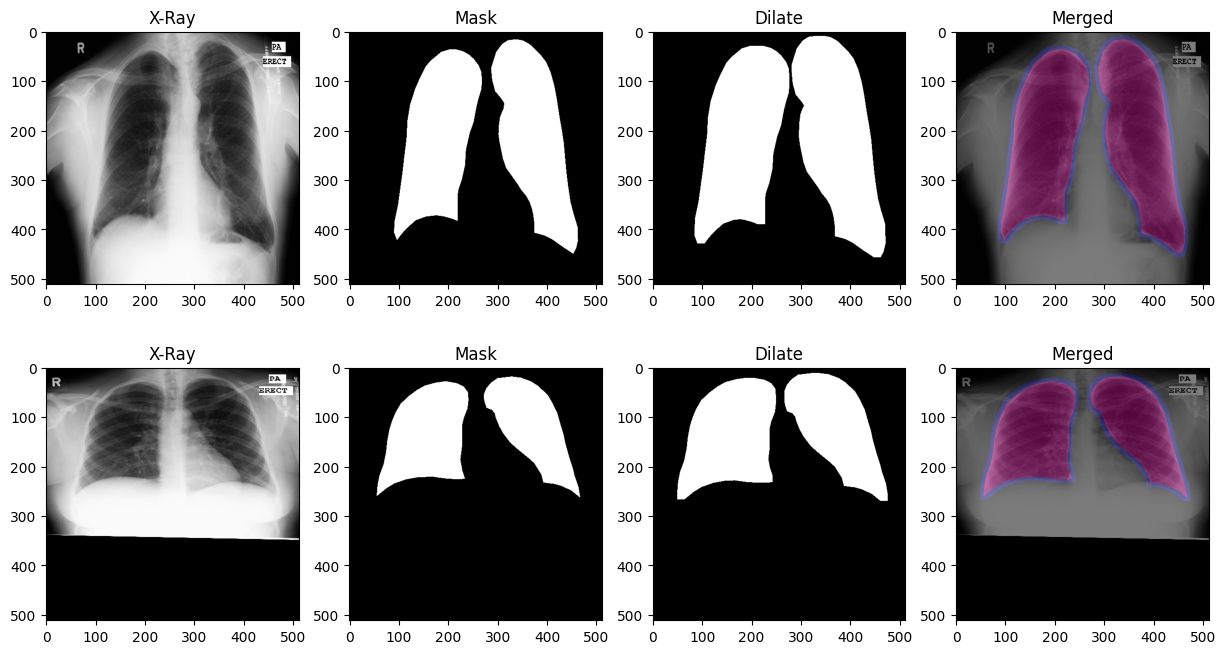

In [ ]:
base_file = os.path.basename(montgomery_train[1])

image_file = os.path.join(SEGMENTATION_IMAGE_DIR, base_file)
mask_image_file = os.path.join(SEGMENTATION_MASK_DIR, base_file)
dilate_image_file = os.path.join(SEGMENTATION_DILATE_DIR, base_file)

image = cv2.imread(image_file)
mask_image = cv2.imread(mask_image_file)
dilate_image = cv2.imread(dilate_image_file)
merged_image = add_colored_dilate(image, mask_image, dilate_image)

fig, axs = plt.subplots(2, 4, figsize=(15, 8))

axs[0, 0].set_title("X-Ray")
axs[0, 0].imshow(image)

axs[0, 1].set_title("Mask")
axs[0, 1].imshow(mask_image)

axs[0, 2].set_title("Dilate")
axs[0, 2].imshow(dilate_image)

axs[0, 3].set_title("Merged")
axs[0, 3].imshow(merged_image)

base_file = os.path.basename(montgomery_test[1])
filename, fileext = os.path.splitext(base_file)
image_file = os.path.join(SEGMENTATION_TEST_DIR, base_file)
mask_image_file = os.path.join(SEGMENTATION_TEST_DIR, \
                               "%s_mask%s" % (filename, fileext))
dilate_image_file = os.path.join(SEGMENTATION_TEST_DIR, \
                                 "%s_dilate%s" % (filename, fileext))

image = cv2.imread(image_file)
mask_image = cv2.imread(mask_image_file)
dilate_image = cv2.imread(dilate_image_file)
merged_image = add_colored_dilate(image, mask_image, dilate_image)

axs[1, 0].set_title("X-Ray")
axs[1, 0].imshow(image)

axs[1, 1].set_title("Mask")
axs[1, 1].imshow(mask_image)

axs[1, 2].set_title("Dilate")
axs[1, 2].imshow(dilate_image)

axs[1, 3].set_title("Merged")
axs[1, 3].imshow(merged_image)

Show some Shenzhen Hospital chest x-rays and its lung segmentation masks from training and test dataset to verify the procedure above. In merged image it is possible to see the difference between the dilated mask in blue and the original mask in red.

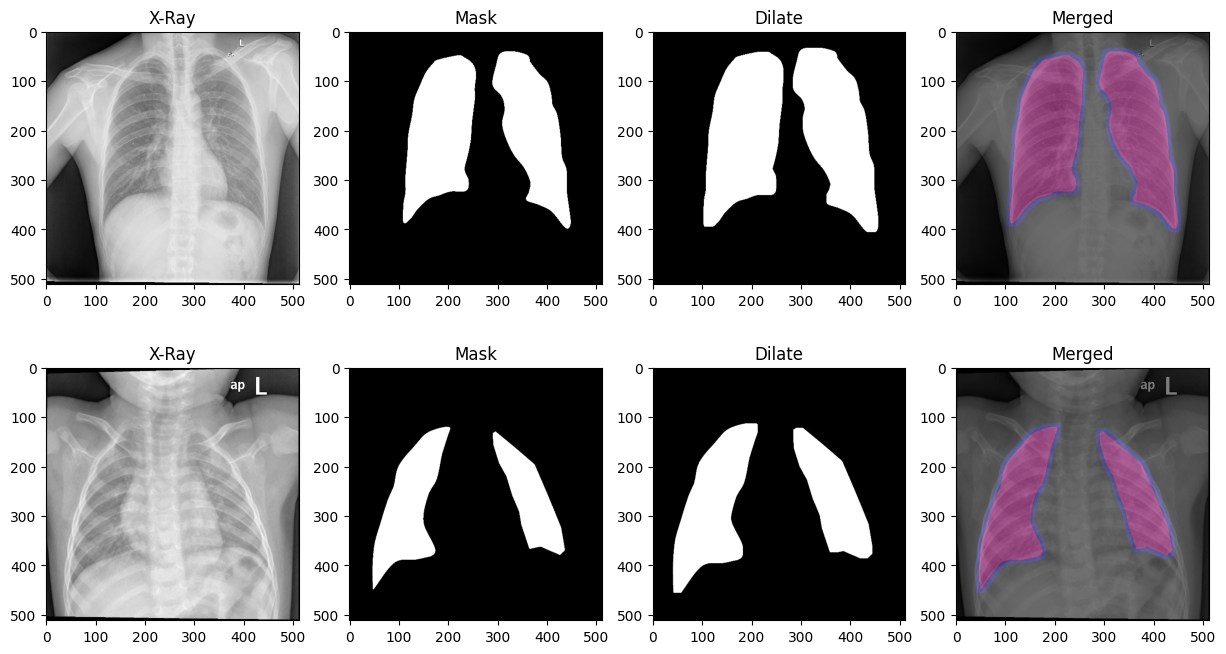

In [ ]:
base_file = os.path.basename(shenzhen_train[2].replace("_mask", ""))
image_file = os.path.join(SEGMENTATION_IMAGE_DIR, base_file)
mask_image_file = os.path.join(SEGMENTATION_MASK_DIR, base_file)
dilate_image_file = os.path.join(SEGMENTATION_DILATE_DIR, base_file)

image = cv2.imread(image_file)
mask_image = cv2.imread(mask_image_file)
dilate_image = cv2.imread(dilate_image_file)
merged_image = add_colored_dilate(image, mask_image, dilate_image)

fig, axs = plt.subplots(2, 4, figsize=(15, 8))

axs[0, 0].set_title("X-Ray")
axs[0, 0].imshow(image)

axs[0, 1].set_title("Mask")
axs[0, 1].imshow(mask_image)

axs[0, 2].set_title("Dilate")
axs[0, 2].imshow(dilate_image)

axs[0, 3].set_title("Merged")
axs[0, 3].imshow(merged_image)

base_file = os.path.basename(shenzhen_test[0].replace("_mask", ""))
image_file = os.path.join(SEGMENTATION_TEST_DIR, base_file)
filename, fileext = os.path.splitext(base_file)
mask_image_file = os.path.join(SEGMENTATION_TEST_DIR, \
                               "%s_mask%s" % (filename, fileext))

filename, fileext = os.path.splitext(base_file)
image_file = os.path.join(SEGMENTATION_TEST_DIR, base_file)
mask_image_file = os.path.join(SEGMENTATION_TEST_DIR, \
                               "%s_mask%s" % (filename, fileext))
dilate_image_file = os.path.join(SEGMENTATION_TEST_DIR, \
                                 "%s_dilate%s" % (filename, fileext))

image = cv2.imread(image_file)
mask_image = cv2.imread(mask_image_file)
dilate_image = cv2.imread(dilate_image_file)
merged_image = add_colored_dilate(image, mask_image, dilate_image)

axs[1, 0].set_title("X-Ray")
axs[1, 0].imshow(image)

axs[1, 1].set_title("Mask")
axs[1, 1].imshow(mask_image)

axs[1, 2].set_title("Dilate")
axs[1, 2].imshow(dilate_image)

axs[1, 3].set_title("Merged")
axs[1, 3].imshow(merged_image)

Print the count of images and segmentation lung masks available to test and train the model

In [ ]:
train_files = glob(os.path.join(SEGMENTATION_IMAGE_DIR, "*.png"))
test_files = glob(os.path.join(SEGMENTATION_TEST_DIR, "*.png"))
mask_files = glob(os.path.join(SEGMENTATION_MASK_DIR, "*.png"))
dilate_files = glob(os.path.join(SEGMENTATION_DILATE_DIR, "*.png"))

(len(train_files),
 len(test_files), \
 len(mask_files), \
 len(dilate_files))

(205, 300, 205, 205)

# **Segmentation with UNET**


## 1. Data augmentation helper function for training the net

### Load train data

In [ ]:
def train_generator(batch_size, train_path, image_folder, mask_folder, aug_dict,
        image_color_mode="grayscale",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):

    image_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_datagen = ImageDataGenerator(**aug_dict)
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)

    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0

    return (img, mask)

### Load test chest x-ray images

In [ ]:
def test_load_image(test_file, target_size=(256,256)):
    img = cv2.imread(test_file, cv2.IMREAD_GRAYSCALE)
    img = img / 255
    img = cv2.resize(img, target_size)
    img = np.reshape(img, img.shape + (1,))
    img = np.reshape(img,(1,) + img.shape)
    return img

def test_generator(test_files, target_size=(256,256)):
    for test_file in test_files:
        img = test_load_image(test_file, target_size)  # Load image
        yield (img,)

def save_result(save_path, npyfile, test_files):
    for i, item in enumerate(npyfile):
        result_file = test_files[i]
        img = (item[:, :, 0] * 255.).astype(np.uint8)

        filename, fileext = os.path.splitext(os.path.basename(result_file))

        result_file = os.path.join(save_path, "%s_predict%s" % (filename, fileext))
        print(f"Saving prediction: {result_file}")
        cv2.imwrite(result_file, img)

def add_suffix(base_file, suffix):
    filename, fileext = os.path.splitext(base_file)
    return "%s_%s%s" % (filename, suffix, fileext)


In [ ]:
test_files = [test_file for test_file in glob(os.path.join(SEGMENTATION_TEST_DIR, "*.png")) \
              if ("_mask" not in test_file \
                  and "_dilate" not in test_file \
                  and "_predict" not in test_file)]

validation_data = (test_load_image(test_files[0], target_size=(512, 512)),
                    test_load_image(add_suffix(test_files[0], "dilate"), target_size=(512, 512)))

len(test_files), len(validation_data)

(100, 2)

## 2. U-net architecture

In [ ]:
import os
import math
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K  # Correct backend import for dice functions

# Define Dice Coefficient and Loss
def dice_coef(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1])  # Fix: Flatten tensor
    y_pred_f = tf.reshape(y_pred, [-1])  # Fix: Flatten tensor
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

# Define U-Net Model
def unet(input_size=(512, 512, 1)):  # Fix: Ensure input_size is properly passed
    inputs = Input(shape=input_size)  # Explicitly define input shape

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=inputs, outputs=conv10)  # Fix: Ensure proper input-output definition
model = unet()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 512, 512, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 512, 512, 32)   │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 512, 512, 32)   │          9,248 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 256, 256, 32)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 256, 256, 64)   │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 128, 128, 64)   │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 64, 64, 128)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 32, 32, 256)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 64, 64, 256)    │        524,544 │ conv2d_9[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 64, 64, 512)    │              0 │ conv2d_transpose[0][0… │
│                      

 Total params: 7,759,521 (29.60 MB)

 Trainable params: 7,759,521 (29.60 MB)

 Non-trainable params: 0 (0.00 B)

Prepare the U-Net model and train the model. It will take a while...

## 3. Train the Unet model

In [ ]:
# Set Parameters
BATCH_SIZE = 8
EPOCHS = 50  # Production Mode
# EPOCHS = 16  # Development Mode (Uncomment for testing)

# Data Augmentation Parameters
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

# Train Data Generator
train_gen = train_generator(BATCH_SIZE,
                            SEGMENTATION_TRAIN_DIR,
                            'image',
                            'dilate',
                            train_generator_args,
                            target_size=(512, 512),
                            save_to_dir=os.path.abspath(SEGMENTATION_AUG_DIR))


# Automatically run on GPU if available
device = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"

with tf.device(device):  # Run model on GPU
# Initialize and Compile Model
  model = unet(input_size=(512, 512, 1))  # Fix: Pass input size properly
  model.compile(optimizer=Adam(learning_rate=1e-5),
                loss=dice_coef_loss,
                metrics=[dice_coef, 'binary_accuracy'])

  # Model Checkpoint Callback
  checkpoint_filepath = "unet_lung_seg.h5"
  model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,
                                    monitor='loss',
                                    verbose=1,
                                    save_best_only=True,
                                    save_weights_only=False)

  # Ensure `train_files` and `validation_data` exist
  if 'train_files' not in globals():
      raise ValueError("train_files is not defined. Ensure it is a list of training images.")

  if 'validation_data' not in globals():
      raise ValueError("validation_data is not defined. Provide a valid validation generator or dataset.")

  # Train Model
  history = model.fit(train_gen,
                      steps_per_epoch=math.ceil(len(train_files) / BATCH_SIZE),  # Ensure integer steps
                      epochs=EPOCHS,
                      callbacks=[model_checkpoint],
                      validation_data=validation_data)


Found 205 images belonging to 1 classes.
Found 205 images belonging to 1 classes.
Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.2964 - dice_coef: 0.3749 - loss: -0.3749
Epoch 1: loss improved from inf to -0.37595, saving model to unet_lung_seg.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 136s 3s/step - binary_accuracy: 0.2965 - dice_coef: 0.3749 - loss: -0.3749 - val_binary_accuracy: 0.2954 - val_dice_coef: 0.3740 - val_loss: -0.3740
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 999ms/step - binary_accuracy: 0.2937 - dice_coef: 0.3731 - loss: -0.3731
Epoch 2: loss improved from -0.37595 to -0.37806, saving model to unet_lung_seg.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - binary_accuracy: 0.2940 - dice_coef: 0.3733 - loss: -0.3733 - val_binary_accuracy: 0.2954 - val_dice_coef: 0.3746 - val_loss: -0.3746
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.3042 - dice_coef: 0.3827 - loss: -0.3827
Epoch 3: loss improved from -0.37806 to -0.38020, saving model to unet_lung_seg.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - binary_accuracy: 0.3041 - dice_coef: 0.3826 - loss: -0.3826 - val_binary_accuracy: 0.2954 - val_dice_coef: 0.3755 - val_loss: -0.3755
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.3021 - dice_coef: 0.3825 - loss: -0.3825
Epoch 4: loss improved from -0.38020 to -0.38085, saving model to unet_lung_seg.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - binary_accuracy: 0.3020 - dice_coef: 0.3824 - loss: -0.3824 - val_binary_accuracy: 0.2954 - val_dice_coef: 0.3768 - val_loss: -0.3768
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.2973 - dice_coef: 0.3809 - loss: -0.3810
Epoch 5: loss improved from -0.38085 to -0.38223, saving model to unet_lung_seg.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - binary_accuracy: 0.2973 - dice_coef: 0.3810 - loss: -0.3810 - val_binary_accuracy: 0.2954 - val_dice_coef: 0.3788 - val_loss: -0.3788
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.2959 - dice_coef: 0.3833 - loss: -0.3833
Epoch 6: loss improved from -0.38223 to -0.38749, saving model to unet_lung_seg.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - binary_accuracy: 0.2960 - dice_coef: 0.3835 - loss: -0.3834 - val_binary_accuracy: 0.2954 - val_dice_coef: 0.3841 - val_loss: -0.3841
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.2922 - dice_coef: 0.3926 - loss: -0.3926
Epoch 7: loss improved from -0.38749 to -0.40683, saving model to unet_lung_seg.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - binary_accuracy: 0.2924 - dice_coef: 0.3932 - loss: -0.3931 - val_binary_accuracy: 0.2954 - val_dice_coef: 0.4335 - val_loss: -0.4335
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.2970 - dice_coef: 0.4589 - loss: -0.4589
Epoch 8: loss improved from -0.40683 to -0.46468, saving model to unet_lung_seg.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - binary_accuracy: 0.2969 - dice_coef: 0.4591 - loss: -0.4592 - val_binary_accuracy: 0.2954 - val_dice_coef: 0.4731 - val_loss: -0.4731
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.2970 - dice_coef: 0.4710 - loss: -0.4710
Epoch 9: loss improved from -0.46468 to -0.47215, saving model to unet_lung_seg.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - binary_accuracy: 0.2970 - dice_coef: 0.4710 - loss: -0.4710 - val_binary_accuracy: 0.2954 - val_dice_coef: 0.4794 - val_loss: -0.4794
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.3040 - dice_coef: 0.4824 - loss: -0.4824
Epoch 10: loss improved from -0.47215 to -0.47742, saving model to unet_lung_seg.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - binary_accuracy: 0.3038 - dice_coef: 0.4822 - loss: -0.4823 - val_binary_accuracy: 0.2954 - val_dice_coef: 0.4874 - val_loss: -0.4874
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.3027 - dice_coef: 0.4886 - loss: -0.4886
Epoch 11: loss improved from -0.47742 to -0.48752, saving model to unet_lung_seg.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - binary_accuracy: 0.3026 - dice_coef: 0.4886 - loss: -0.4886 - val_binary_accuracy: 0.2964 - val_dice_coef: 0.5053 - val_loss: -0.5053
Epoch 12/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.3092 - dice_coef: 0.5119 - loss: -0.5119
Epoch 12: loss improved from -0.48752 to -0.50877, saving model to unet_lung_seg.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - binary_accuracy: 0.3091 - dice_coef: 0.5118 - loss: -0.5118 - val_binary_accuracy: 0.3398 - val_dice_coef: 0.5325 - val_loss: -0.5325
Epoch 13/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.3812 - dice_coef: 0.5218 - loss: -0.5218
Epoch 13: loss improved from -0.50877 to -0.52443, saving model to unet_lung_seg.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - binary_accuracy: 0.3841 - dice_coef: 0.5220 - loss: -0.5219 - val_binary_accuracy: 0.7277 - val_dice_coef: 0.5586 - val_loss: -0.5586
Epoch 14/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.6573 - dice_coef: 0.5401 - loss: -0.5401
Epoch 14: loss improved from -0.52443 to -0.55935, saving model to unet_lung_seg.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - binary_accuracy: 0.6584 - dice_coef: 0.5408 - loss: -0.5408 - val_binary_accuracy: 0.8325 - val_dice_coef: 0.6549 - val_loss: -0.6549
Epoch 15/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.7138 - dice_coef: 0.5794 - loss: -0.5794
Epoch 15: loss improved from -0.55935 to -0.56018, saving model to unet_lung_seg.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - binary_accuracy: 0.7112 - dice_coef: 0.5787 - loss: -0.5787 - val_binary_accuracy: 0.6791 - val_dice_coef: 0.6387 - val_loss: -0.6387
Epoch 16/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.6470 - dice_coef: 0.6014 - loss: -0.6014
Epoch 16: loss improved from -0.56018 to -0.62456, saving model to unet_lung_seg.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - binary_accuracy: 0.6485 - dice_coef: 0.6022 - loss: -0.6022 - val_binary_accuracy: 0.8376 - val_dice_coef: 0.7061 - val_loss: -0.7061
Epoch 17/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.7670 - dice_coef: 0.6483 - loss: -0.6484
Epoch 17: loss improved from -0.62456 to -0.64972, saving model to unet_lung_seg.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - binary_accuracy: 0.7663 - dice_coef: 0.6483 - loss: -0.6484 - val_binary_accuracy: 0.8322 - val_dice_coef: 0.7522 - val_loss: -0.7522
Epoch 18/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.6196 - dice_coef: 0.6008 - loss: -0.6008
Epoch 18: loss did not improve from -0.64972
26/26 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - binary_accuracy: 0.6188 - dice_coef: 0.6004 - loss: -0.6004 - val_binary_accuracy: 0.7108 - val_dice_coef: 0.6465 - val_loss: -0.6465
Epoch 19/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.6741 - dice_coef: 0.6304 - loss: -0.6304
Epoch 19: loss did not improve from -0.64972
26/26 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - binary_accuracy: 0.6748 - dice_coef: 0.6308 - loss: -0.6308 - val_binary_accuracy: 0.8293 - val_dice_coef: 0.7247 - val_loss: -0.7247
Epoch 20/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.7537 - dice_coef: 0.6544 - loss: -0.6544
Epoch 20: loss did not improve from -0.64972
26/2

26/26 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - binary_accuracy: 0.7244 - dice_coef: 0.6535 - loss: -0.6535 - val_binary_accuracy: 0.8714 - val_dice_coef: 0.7264 - val_loss: -0.7264
Epoch 22/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.8025 - dice_coef: 0.6884 - loss: -0.6884
Epoch 22: loss improved from -0.66253 to -0.67850, saving model to unet_lung_seg.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - binary_accuracy: 0.8017 - dice_coef: 0.6880 - loss: -0.6880 - val_binary_accuracy: 0.8842 - val_dice_coef: 0.7597 - val_loss: -0.7597
Epoch 23/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.7555 - dice_coef: 0.6511 - loss: -0.6511
Epoch 23: loss did not improve from -0.67850
26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - binary_accuracy: 0.7547 - dice_coef: 0.6514 - loss: -0.6514 - val_binary_accuracy: 0.8778 - val_dice_coef: 0.7509 - val_loss: -0.7509
Epoch 24/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.8396 - dice_coef: 0.7048 - loss: -0.7048
Epoch 24: loss improved from -0.67850 to -0.69165, saving model to unet_lung_seg.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - binary_accuracy: 0.8391 - dice_coef: 0.7044 - loss: -0.7044 - val_binary_accuracy: 0.8369 - val_dice_coef: 0.7769 - val_loss: -0.7769
Epoch 25/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.7111 - dice_coef: 0.6609 - loss: -0.6609
Epoch 25: loss did not improve from -0.69165
26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - binary_accuracy: 0.7112 - dice_coef: 0.6609 - loss: -0.6609 - val_binary_accuracy: 0.8649 - val_dice_coef: 0.7626 - val_loss: -0.7626
Epoch 26/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.8071 - dice_coef: 0.6938 - loss: -0.6938
Epoch 26: loss improved from -0.69165 to -0.70085, saving model to unet_lung_seg.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - binary_accuracy: 0.8074 - dice_coef: 0.6941 - loss: -0.6940 - val_binary_accuracy: 0.8948 - val_dice_coef: 0.7874 - val_loss: -0.7874
Epoch 27/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.8021 - dice_coef: 0.7006 - loss: -0.7006
Epoch 27: loss did not improve from -0.70085
26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - binary_accuracy: 0.8018 - dice_coef: 0.7005 - loss: -0.7005 - val_binary_accuracy: 0.8948 - val_dice_coef: 0.7884 - val_loss: -0.7884
Epoch 28/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.8484 - dice_coef: 0.7209 - loss: -0.7208
Epoch 28: loss improved from -0.70085 to -0.72299, saving model to unet_lung_seg.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - binary_accuracy: 0.8482 - dice_coef: 0.7210 - loss: -0.7209 - val_binary_accuracy: 0.9087 - val_dice_coef: 0.8216 - val_loss: -0.8216
Epoch 29/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.8671 - dice_coef: 0.7514 - loss: -0.7514
Epoch 29: loss improved from -0.72299 to -0.74863, saving model to unet_lung_seg.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - binary_accuracy: 0.8670 - dice_coef: 0.7512 - loss: -0.7513 - val_binary_accuracy: 0.9154 - val_dice_coef: 0.8355 - val_loss: -0.8355
Epoch 30/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.8174 - dice_coef: 0.7108 - loss: -0.7108
Epoch 30: loss did not improve from -0.74863
26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - binary_accuracy: 0.8178 - dice_coef: 0.7113 - loss: -0.7112 - val_binary_accuracy: 0.9111 - val_dice_coef: 0.8457 - val_loss: -0.8457
Epoch 31/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.8275 - dice_coef: 0.7327 - loss: -0.7327
Epoch 31: loss did not improve from -0.74863
26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - binary_accuracy: 0.8273 - dice_coef: 0.7323 - loss: -0.7323 - val_binary_accuracy: 0.9018 - val_dice_coef: 0.8050 - val_loss: -0.8050
Epoch 32/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.8237 - dice_coef: 0.7194 - loss: -0.7194
Epoch 32: loss did not improve from -0.74863
26/2

26/26 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - binary_accuracy: 0.8588 - dice_coef: 0.7538 - loss: -0.7538 - val_binary_accuracy: 0.9268 - val_dice_coef: 0.8615 - val_loss: -0.8615
Epoch 34/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.8913 - dice_coef: 0.7958 - loss: -0.7958
Epoch 34: loss improved from -0.77009 to -0.78815, saving model to unet_lung_seg.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - binary_accuracy: 0.8910 - dice_coef: 0.7955 - loss: -0.7955 - val_binary_accuracy: 0.9063 - val_dice_coef: 0.8146 - val_loss: -0.8146
Epoch 35/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.8751 - dice_coef: 0.7695 - loss: -0.7695
Epoch 35: loss did not improve from -0.78815
26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - binary_accuracy: 0.8754 - dice_coef: 0.7701 - loss: -0.7701 - val_binary_accuracy: 0.9399 - val_dice_coef: 0.8895 - val_loss: -0.8895
Epoch 36/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.8619 - dice_coef: 0.7732 - loss: -0.7732
Epoch 36: loss improved from -0.78815 to -0.78878, saving model to unet_lung_seg.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - binary_accuracy: 0.8624 - dice_coef: 0.7738 - loss: -0.7738 - val_binary_accuracy: 0.9330 - val_dice_coef: 0.8745 - val_loss: -0.8745
Epoch 37/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.8969 - dice_coef: 0.8113 - loss: -0.8113
Epoch 37: loss improved from -0.78878 to -0.80849, saving model to unet_lung_seg.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - binary_accuracy: 0.8968 - dice_coef: 0.8112 - loss: -0.8112 - val_binary_accuracy: 0.9426 - val_dice_coef: 0.8951 - val_loss: -0.8951
Epoch 38/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.9007 - dice_coef: 0.8202 - loss: -0.8202
Epoch 38: loss improved from -0.80849 to -0.82808, saving model to unet_lung_seg.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - binary_accuracy: 0.9008 - dice_coef: 0.8205 - loss: -0.8205 - val_binary_accuracy: 0.9459 - val_dice_coef: 0.9034 - val_loss: -0.9034
Epoch 39/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.9113 - dice_coef: 0.8390 - loss: -0.8390
Epoch 39: loss improved from -0.82808 to -0.83600, saving model to unet_lung_seg.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - binary_accuracy: 0.9112 - dice_coef: 0.8389 - loss: -0.8389 - val_binary_accuracy: 0.9454 - val_dice_coef: 0.9030 - val_loss: -0.9030
Epoch 40/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.9137 - dice_coef: 0.8479 - loss: -0.8479
Epoch 40: loss improved from -0.83600 to -0.84173, saving model to unet_lung_seg.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - binary_accuracy: 0.9136 - dice_coef: 0.8477 - loss: -0.8477 - val_binary_accuracy: 0.9459 - val_dice_coef: 0.9026 - val_loss: -0.9026
Epoch 41/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.8992 - dice_coef: 0.8208 - loss: -0.8208
Epoch 41: loss did not improve from -0.84173
26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - binary_accuracy: 0.8993 - dice_coef: 0.8211 - loss: -0.8211 - val_binary_accuracy: 0.9424 - val_dice_coef: 0.9011 - val_loss: -0.9011
Epoch 42/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.9033 - dice_coef: 0.8386 - loss: -0.8386
Epoch 42: loss improved from -0.84173 to -0.85019, saving model to unet_lung_seg.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - binary_accuracy: 0.9037 - dice_coef: 0.8390 - loss: -0.8390 - val_binary_accuracy: 0.9439 - val_dice_coef: 0.9031 - val_loss: -0.9031
Epoch 43/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.9139 - dice_coef: 0.8519 - loss: -0.8519
Epoch 43: loss improved from -0.85019 to -0.85528, saving model to unet_lung_seg.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - binary_accuracy: 0.9140 - dice_coef: 0.8520 - loss: -0.8520 - val_binary_accuracy: 0.9459 - val_dice_coef: 0.9060 - val_loss: -0.9060
Epoch 44/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.9182 - dice_coef: 0.8595 - loss: -0.8595
Epoch 44: loss improved from -0.85528 to -0.85817, saving model to unet_lung_seg.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - binary_accuracy: 0.9182 - dice_coef: 0.8595 - loss: -0.8594 - val_binary_accuracy: 0.9457 - val_dice_coef: 0.9053 - val_loss: -0.9053
Epoch 45/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.9153 - dice_coef: 0.8553 - loss: -0.8553
Epoch 45: loss improved from -0.85817 to -0.85826, saving model to unet_lung_seg.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - binary_accuracy: 0.9154 - dice_coef: 0.8554 - loss: -0.8554 - val_binary_accuracy: 0.9462 - val_dice_coef: 0.9089 - val_loss: -0.9089
Epoch 46/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.9158 - dice_coef: 0.8574 - loss: -0.8574
Epoch 46: loss did not improve from -0.85826
26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - binary_accuracy: 0.9158 - dice_coef: 0.8574 - loss: -0.8574 - val_binary_accuracy: 0.9464 - val_dice_coef: 0.9090 - val_loss: -0.9090
Epoch 47/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.9193 - dice_coef: 0.8630 - loss: -0.8630
Epoch 47: loss improved from -0.85826 to -0.86090, saving model to unet_lung_seg.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - binary_accuracy: 0.9193 - dice_coef: 0.8629 - loss: -0.8629 - val_binary_accuracy: 0.9482 - val_dice_coef: 0.9099 - val_loss: -0.9099
Epoch 48/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.9182 - dice_coef: 0.8561 - loss: -0.8561
Epoch 48: loss did not improve from -0.86090
26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - binary_accuracy: 0.9183 - dice_coef: 0.8562 - loss: -0.8562 - val_binary_accuracy: 0.9463 - val_dice_coef: 0.9097 - val_loss: -0.9097
Epoch 49/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.9176 - dice_coef: 0.8562 - loss: -0.8562
Epoch 49: loss improved from -0.86090 to -0.86257, saving model to unet_lung_seg.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - binary_accuracy: 0.9177 - dice_coef: 0.8565 - loss: -0.8564 - val_binary_accuracy: 0.9468 - val_dice_coef: 0.9110 - val_loss: -0.9110
Epoch 50/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.9221 - dice_coef: 0.8671 - loss: -0.8671
Epoch 50: loss did not improve from -0.86257
26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - binary_accuracy: 0.9220 - dice_coef: 0.8669 - loss: -0.8668 - val_binary_accuracy: 0.9313 - val_dice_coef: 0.8901 - val_loss: -0.8901


## 4. Test model


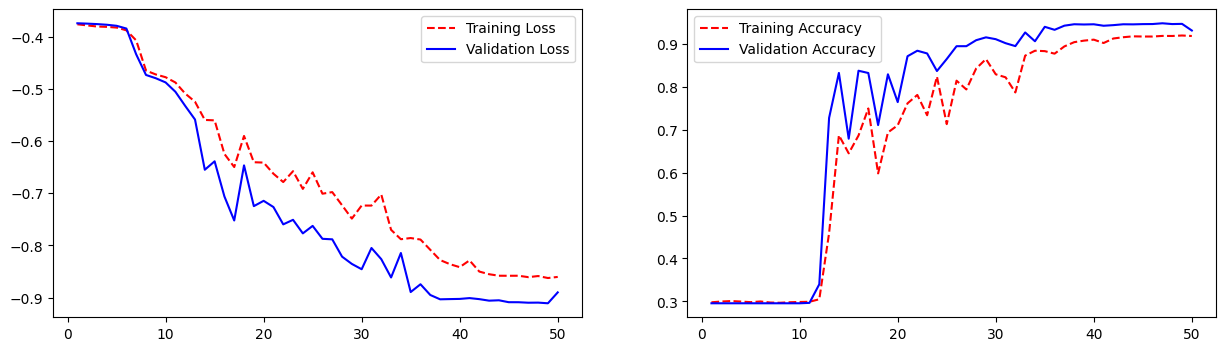

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (15, 4))

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

training_accuracy = history.history['binary_accuracy']
validation_accuracy = history.history['val_binary_accuracy']

epoch_count = range(1, len(training_loss) + 1)

axs[0].plot(epoch_count, training_loss, 'r--')
axs[0].plot(epoch_count, validation_loss, 'b-')
axs[0].legend(['Training Loss', 'Validation Loss'])

axs[1].plot(epoch_count, training_accuracy, 'r--')
axs[1].plot(epoch_count, validation_accuracy, 'b-')
axs[1].legend(['Training Accuracy', 'Validation Accuracy'])

Below, we see some results from our work, presented as Predicted, Gold Standard (manually segmented) and the difference between segmentations.

In [ ]:
test_gen = test_generator(test_files, target_size=(512, 512))
results = model.predict(test_gen, verbose=1)
save_result(SEGMENTATION_TEST_DIR, results, test_files)

100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Saving prediction: /content/drive/MyDrive/Deep Learning/datasets/segmentation/test/MCUCXR_0001_0_predict.png
Saving prediction: /content/drive/MyDrive/Deep Learning/datasets/segmentation/test/MCUCXR_0048_0_predict.png
Saving prediction: /content/drive/MyDrive/Deep Learning/datasets/segmentation/test/MCUCXR_0051_0_predict.png
Saving prediction: /content/drive/MyDrive/Deep Learning/datasets/segmentation/test/MCUCXR_0041_0_predict.png
Saving prediction: /content/drive/MyDrive/Deep Learning/datasets/segmentation/test/MCUCXR_0011_0_predict.png
Saving prediction: /content/drive/MyDrive/Deep Learning/datasets/segmentation/test/MCUCXR_0005_0_predict.png
Saving prediction: /content/drive/MyDrive/Deep Learning/datasets/segmentation/test/MCUCXR_0026_0_predict.png
Saving prediction: /content/drive/MyDrive/Deep Learning/datasets/segmentation/test/MCUCXR_0015_0_predict.png
Saving prediction: /content/drive/MyDrive/Deep Learning/datasets/segmentation/test/MCUCXR_0021_0_predict.png
Saving prediction: 

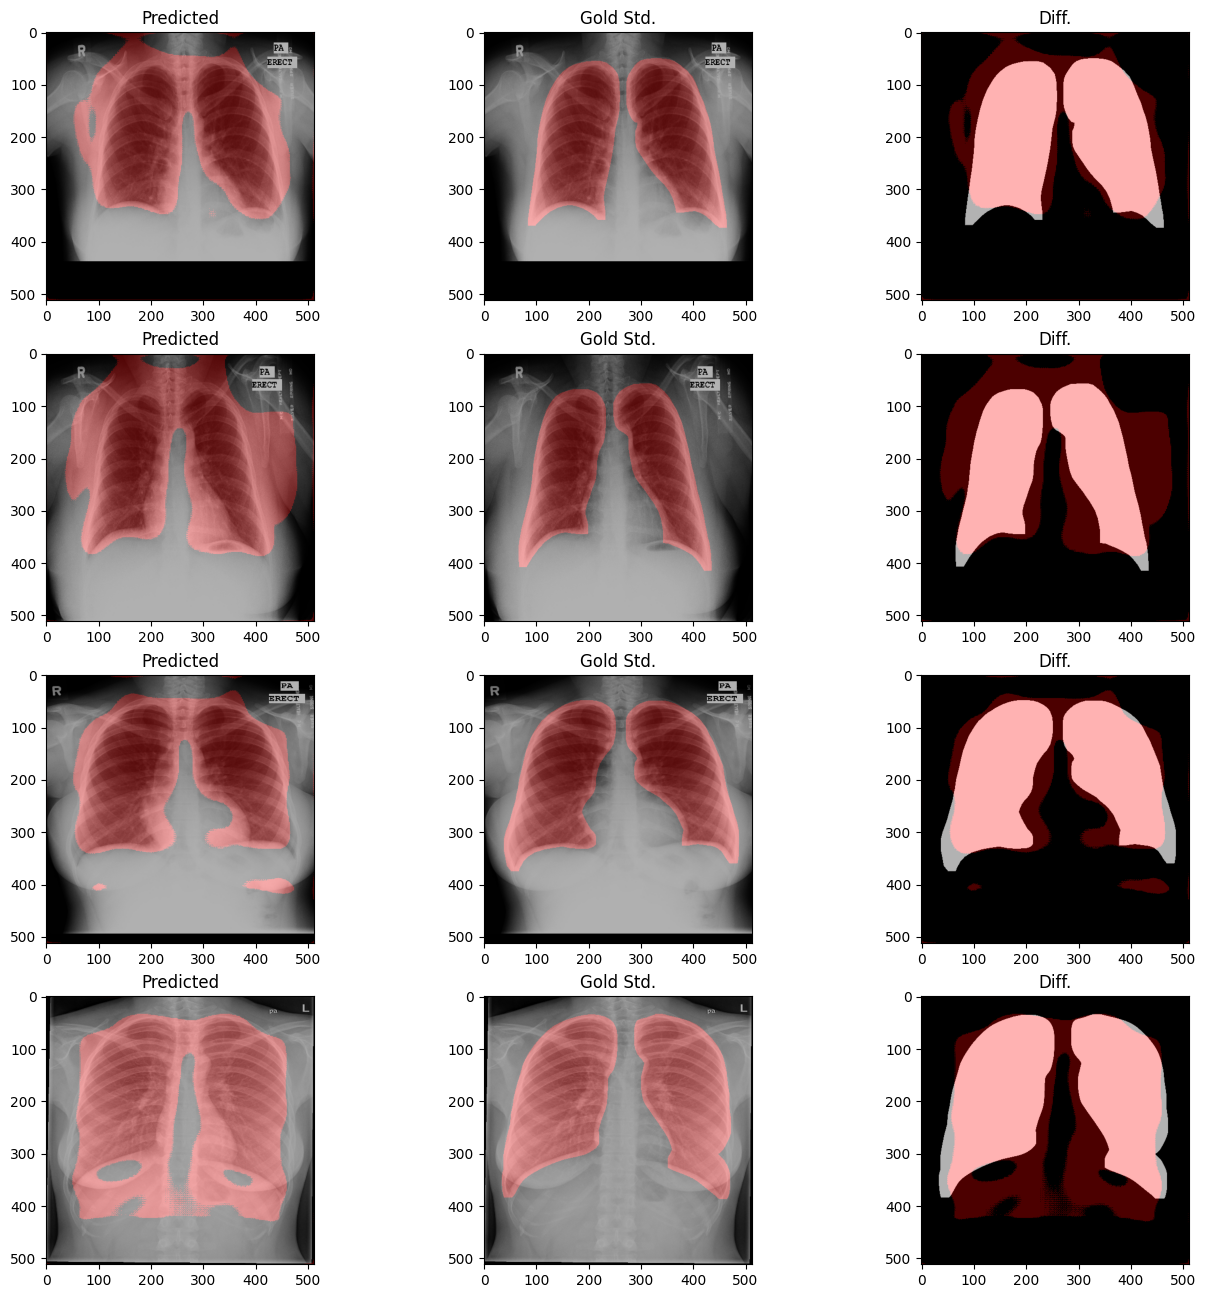

In [ ]:
fig, axs = plt.subplots(4, 3, figsize=(16, 16))

image = cv2.imread("/content/drive/MyDrive/Deep Learning/datasets/segmentation/test/MCUCXR_0001_0.png")
predict_image = cv2.imread("/content/drive/MyDrive/Deep Learning/datasets/segmentation/test/MCUCXR_0001_0_predict.png")
mask_image = cv2.imread("/content/drive/MyDrive/Deep Learning/datasets/segmentation/test/MCUCXR_0001_0_dilate.png")
axs[0, 0].set_title("Predicted")
axs[0, 0].imshow(add_colored_mask(image, predict_image))
axs[0, 1].set_title("Gold Std.")
axs[0, 1].imshow(add_colored_mask(image, mask_image))
axs[0, 2].set_title("Diff.")
axs[0, 2].imshow(diff_mask(mask_image, predict_image))

image = cv2.imread("/content/drive/MyDrive/Deep Learning/datasets/segmentation/test/MCUCXR_0002_0.png")
predict_image = cv2.imread("/content/drive/MyDrive/Deep Learning/datasets/segmentation/test/MCUCXR_0002_0_predict.png")
mask_image = cv2.imread("/content/drive/MyDrive/Deep Learning/datasets/segmentation/test/MCUCXR_0002_0_dilate.png")
axs[1, 0].set_title("Predicted")
axs[1, 0].imshow(add_colored_mask(image, predict_image))
axs[1, 1].set_title("Gold Std.")
axs[1, 1].imshow(add_colored_mask(image, mask_image))
axs[1, 2].set_title("Diff.")
axs[1, 2].imshow(diff_mask(mask_image, predict_image))

image = cv2.imread("/content/drive/MyDrive/Deep Learning/datasets/segmentation/test/MCUCXR_0003_0.png")
predict_image = cv2.imread("/content/drive/MyDrive/Deep Learning/datasets/segmentation/test/MCUCXR_0003_0_predict.png")
mask_image = cv2.imread("/content/drive/MyDrive/Deep Learning/datasets/segmentation/test/MCUCXR_0003_0_dilate.png")
axs[2, 0].set_title("Predicted")
axs[2, 0].imshow(add_colored_mask(image, predict_image))
axs[2, 1].set_title("Gold Std.")
axs[2, 1].imshow(add_colored_mask(image, mask_image))
axs[2, 2].set_title("Diff.")
axs[2, 2].imshow(diff_mask(mask_image, predict_image))

image = cv2.imread("/content/drive/MyDrive/Deep Learning/datasets/segmentation/test/CHNCXR_0103_0.png")
predict_image = cv2.imread("/content/drive/MyDrive/Deep Learning/datasets/segmentation/test/CHNCXR_0103_0_predict.png")
mask_image = cv2.imread("/content/drive/MyDrive/Deep Learning/datasets/segmentation/test/CHNCXR_0103_0_dilate.png")
axs[3, 0].set_title("Predicted")
axs[3, 0].imshow(add_colored_mask(image, predict_image))
axs[3, 1].set_title("Gold Std.")
axs[3, 1].imshow(add_colored_mask(image, mask_image))
axs[3, 2].set_title("Diff.")
axs[3, 2].imshow(diff_mask(mask_image, predict_image))

# **Apply pretrained-model to RSNA dataset**

The next step will be the selection of lungs area on RSNA images dataset and the generation of a lungs-only image dataset.

In [ ]:
!pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 33.2 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import pydicom
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
from io import BytesIO
from PIL import Image
import zipfile as zf

import tensorflow as tf
from tensorflow.keras import layers, Model

In [ ]:
# from google.colab import files
# files.upload()  # Upload kaggle.json

# import os
# !mkdir -p ~/.kaggle
# !mv kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle competitions download -c rsna-pneumonia-detection-challenge

Saving kaggle.json to kaggle.json
100% 3.66G/3.66G [00:53<00:00, 24.2MB/s]
100% 3.66G/3.66G [00:53<00:00, 73.1MB/s]


In [ ]:
base_rsna_dir = "/content/drive/MyDrive/Deep Learning/datasets/rsna_dataset"
train_X, train_Y = next(iter(train_gen))
mean, std = train_X.mean(), train_X.std()

def read_dicom_as_float(in_path):
    dicom = pydicom.dcmread(in_path)
    img = dicom.pixel_array.astype(np.float32)
    img = (img - np.mean(img)) / np.std(img)
    img = img * std + mean

    return np.expand_dims(img, axis=-1)  # Shape: (H, W, 1)

all_rsna_df = pd.DataFrame({'path': glob(os.path.join(base_rsna_dir, 'stage_*_images', '*.dcm'))})
sample_img = read_dicom_as_float(all_rsna_df.iloc[0, 0])
in_shape = sample_img.shape
in_shape

(1024, 1024, 1)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['DICOMInput']
Received: inputs=Tensor(shape=(1, 1024, 1024, 1))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


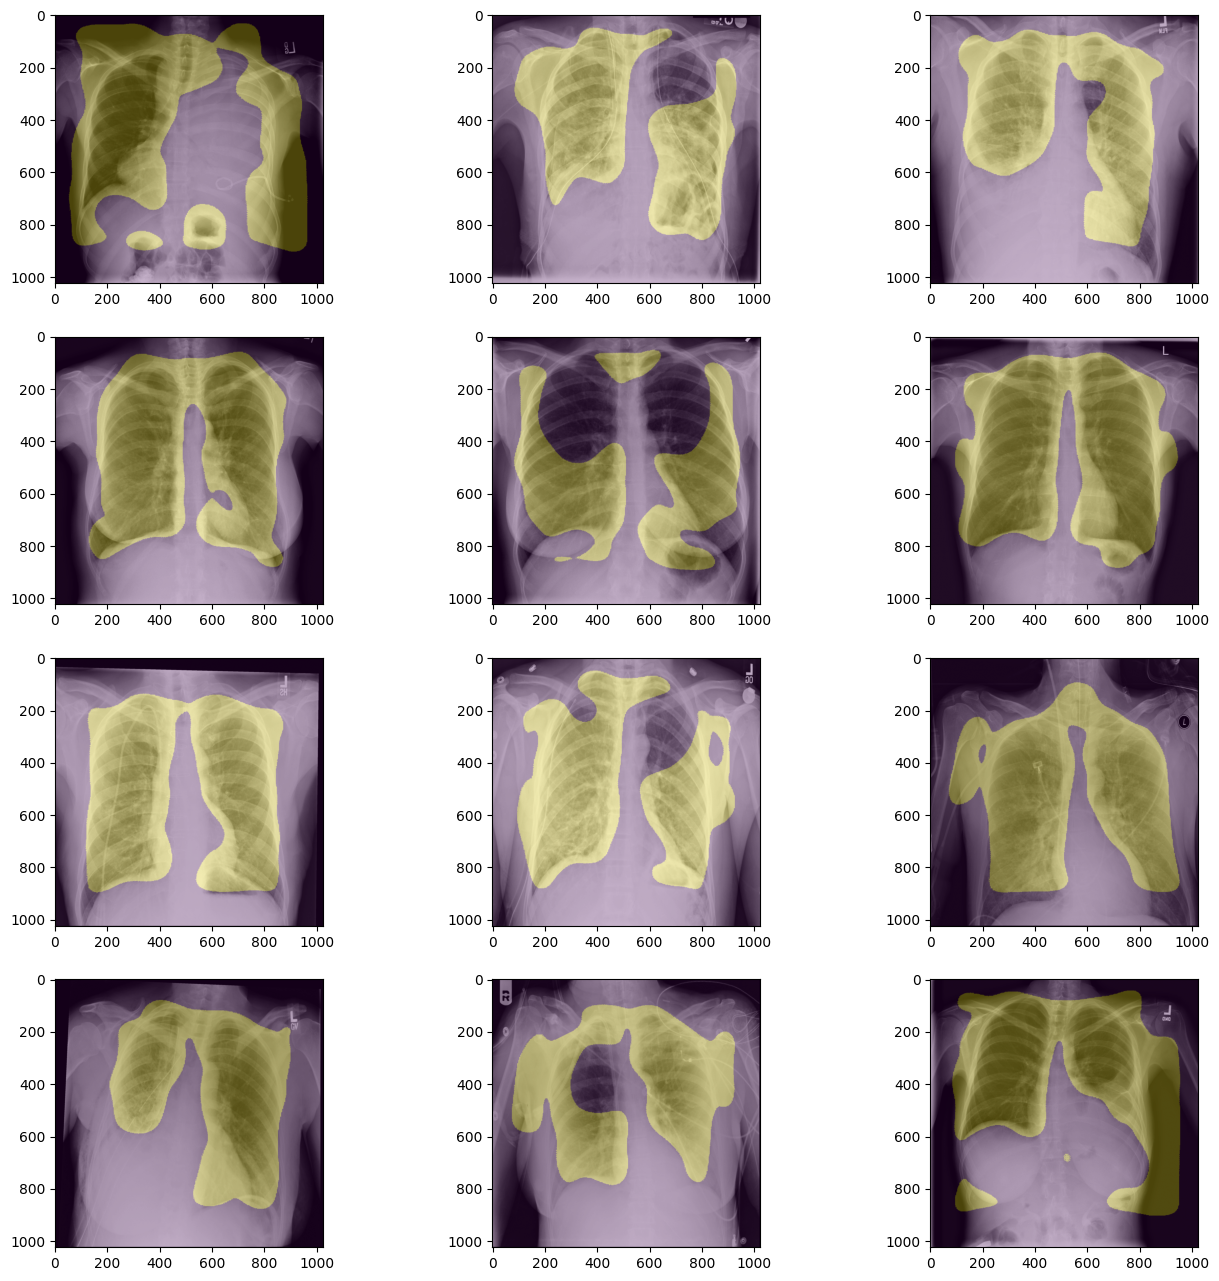

In [ ]:
# Downsample using AvgPool2D
scale_factor = (2, 2)
in_img = layers.Input(in_shape, name='DICOMInput')
ds_dicom = layers.AvgPool2D(scale_factor)(in_img)
unet_out = model(ds_dicom)

us_out = layers.UpSampling2D(scale_factor)(unet_out)
unet_big = Model(inputs=[in_img], outputs=[us_out])
unet_big.save('unet_rsna_model.h5')

fig, axs = plt.subplots(4, 3, figsize=(16, 16))
for c_ax, (_, c_row) in zip(axs.flatten(), all_rsna_df[:12].iterrows()):
    img = read_dicom_as_float(c_row['path'])
    pred = unet_big.predict(np.expand_dims(img, axis=0))[0]
    c_ax.imshow(img[:, :, 0], cmap="gray")
    c_ax.imshow(pred[:, :, 0] > 0.5, alpha=0.3)  # Overlay prediction
plt.show()